# Gaussian Process Tutorial for Perovskite Characterization
Thomas Coons 2023

In this tutorial, we'll walk through the steps I took to train the GP for interfacial toughness, then we will also go through how to use the model to make predictions. My goal is to help you build some intuition about the model, understand the specific steps I took (which may not necessarily be the best - your feedback is helpful since you understand the application better than I do!), and to be able to use my code to generate plots and results of your choosing.

First, we import some helpful packages, the most important of which is GPyTorch, a flexible GP code base that is built on BOTorch.

In [23]:
# %% import necessary tools
import sys
print(sys.executable)

print("import necessary tools")
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import math
import torch
import gpytorch
import pandas as pd
import tqdm as notebook_tqdm

/Users/me-tcoons/opt/anaconda3/bin/python
import necessary tools


# Step One: Importing and Formatting Data

There are several steps that are usually taken when fitting a data-driven model: scaling the data, and dividing the test/train/validation split.

## Why apply a logarithm to the output data?

In this whole process, we are assuming that the true interfacial toughness $y$ can be represented by a true underlying mapping $G(x)$ from the input space $x \in \mathbb{R}^{3}$ (the temperature, pressure, and time inputs) to the output space $y \in \mathbb{R}$, with some additive uncertainty $\epsilon$. Symbolically, we are assuming:
\begin{equation}
y=G(x)+\epsilon.
\end{equation}

Ideally, we would model the underlying truth $y$ via a surrogate, say $\hat{G}(x)$. However, since we plan to use a Gaussian Process to predict outputs $y \geq 0$, whose predictions will be Gaussian (and Gaussian distributions have no strict upper/lower bounds, i.e. they may have samples of $y$ that are negative), we are actually interested in finding a $\hat{G}: x \rightarrow \ln{(y)}$ since a Gaussian distribution on $\ln{(y)}$ produces strictly positive predictions when exponentiated. Therefore, we seek:
\begin{equation}
\ln{(y)}=\hat{G}(x) + \eta
\end{equation}
where the measurements of $\ln{(y)}$ are themselves Gaussian random variables (and therefore $y$ is assumed to be a log-normal random variable).

In [24]:
#%% import data
from sklearn.model_selection import train_test_split
print("import data")
df = pd.read_csv('20230628_Interfacial-Toughness.csv')  
# Uncomment the line below to get a fresh split!
#df = df.sample(frac=1)
x = df.iloc[:,1:4]
y = df.loc[:,"Toughness (J/m^2)"]
noises = df.loc[:,"Stdev (J/m^2)"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.02,random_state=48)
_, _, noises_train, noises_test = train_test_split(x,noises,test_size=0.02,random_state=48)

# converting these objects from pandas dataframe to tensor in the cringiest way possible
x_train = torch.tensor(np.array(x_train))
y_train = torch.tensor(np.array(y_train))
noises_train = torch.tensor(np.array(noises_train))
noises_test = torch.tensor(np.array(noises_test))
x_test = torch.tensor(np.array(x_test))
y_test = torch.tensor(np.array(y_test))

import data


## Why scale the data?

For almost all data-driven models, normalizing the input and output data can dramatically improve model performance. One intuitive way to think about this is to consider the case where one input or output ranges from say 0 to 1000 while another ranges from 0 to 1. When the model is updated and optimized according to say MSE, will it take the two outputs into equal consideration? Probably not, because the MSE of the output vector is dominated by the larger component, and the model may not consider all of the outputs equally during training.

Here, we center and scale the inputs and outputs so that they roughly match a standard normal distribution, $N(0,1)$. This is a best practice for GPs.

In scikit-learn, there is a StandardScaler tool that does exactly this. To transform "physical" quantities of interfacial toughness to the scaled output, use $\mathtt{y\_scaler.transform(y\_unscaled)}$, and to do the inverse transformation to get scaled output from the GP into the units J/m^2, use $\mathtt{y\_scaler.inverse\_transform(y\_scaled)}$.

Also note that the $\mathtt{noises}$ (I will explain how they are used more later on) need to also be normalized by dividing by the standard deviation of the output data. We do not use the standard scaler here because we do not want these values to be centered, just scaled the same way we scaled the outputs $y$. These noises represent the uncertainty (standard deviations) of each observation, uncertainty information that the GP can be trained on rather than taking the data to be exact.

In [25]:
#%% pre process data
from sklearn import preprocessing

# scale x data per standard scaler to N(0,1)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = torch.tensor(scaler.transform(x_train))
x_test = torch.tensor(scaler.transform(x_test))

# need to scale noises only by dividing by stdev of (scaled and log'd) inputs
noises_train = noises_train/torch.std(y_train)
noises_train = noises_train/2 # divide by sqrt(n) (this may be wrong if n_samples =/= 4!!!!)

# scale y data to N(0,1)
y_test = torch.log(y_test)
y_train = torch.log(y_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))
y_train = torch.tensor(y_scaler.transform(y_train.reshape(-1,1))).squeeze()
y_test = torch.tensor(y_scaler.transform(y_test.reshape(-1,1))).squeeze()
nTrain = y_train.size(dim=0)

# new content!
x_train_mean = torch.zeros(nTrain)
x_train_distribution = torch.stack((x_train_mean, (noises_train**2).log()), dim=1)

# checking dimensions of test/training set
print(x_train.size())
print(y_train.size())
print(x_test.size())
print(y_test.size())
print(noises_train.size())


torch.Size([77, 3])
torch.Size([77])
torch.Size([20, 3])
torch.Size([20])
torch.Size([77])


## Step Two: Defining our GP Model

A Gaussian Process model embeds the assumption that any finite number of random variables produced by the model are jointly Gaussian. In other words, any outputs predicted by the GP are related by a multivariate Gaussian distribution, which can either be sampled from (producing scalar outputs) or taken as random variables (producing RV outputs). To make these predictions, the GP is defined by a mean function $m(x)$ and a kernel or covariance function $k(x,x')$:
\begin{equation}
    f(x) \sim GP\left( m(x), k(x,x') \right),
\end{equation}
with outputs associated with an input $x_{i} \in \mathbb{R}^{3}$:
\begin{equation}
    y_{i} = N\left(m(x_{i}), k(x_{i},x') \right).
\end{equation}

In our case, the mean function $m(x)$ is a linear 

In [26]:
#%%
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.GaussianSymmetrizedKLKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=noises_train,learn_additional_noise=True)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train_distribution, y_train, likelihood)

# need to find way to set prior variance (constant in front of RBF kernel)

## Step Three: tuning the kernel (hyper) paramaters

It is usually pretty hard to encode prior information (from say physical intuition) into the kernel/covariance function. As a reminder, the kernel is the function that determines how smooth or continuous the GP outputs will be across the domain: it answers the question of how much one point is expected to influence another point of a certain distance away. As a result, it is often necessary to tune the hyperparameters of the kernel (usually a length scale metric) using the data. Here, we use a loss function of the Marginal Log Likelihood to find a lengthscale for each of the three inputs that minimizes the misfit between the data and the model.

In [27]:
# %%
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.25)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter=200

print('Starting GP parameter tuning...')
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train_distribution)
    # Calc loss and backprop gradients
    with gpytorch.settings.cholesky_jitter(1e-1):
        loss = -mll(output, y_train)
    loss.backward()
    if np.mod(i,20)==0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale[0][0].item(),
        model.likelihood.noise.item()
        ))
        #print('Iter %d/%d - Loss: %.3f   lengthscale 1: %.3f   lengthscale 2: %.3f   lengthscale 3: %.3f' % (
        #    i + 1, training_iter, loss.item(),
        #    model.covar_module.base_kernel.lengthscale[0][0].item(),
        #    model.covar_module.base_kernel.lengthscale[0][1].item(),
        #    model.covar_module.base_kernel.lengthscale[0][1].item(),
        #))
        #print('Iter %d/%d - Loss: %.3f %' (
        #    i + 1, training_iter, loss.item()
            #model.covar_module.base_kernel.lengthscale,
            #model.covar_module.base_kernel.lengthscale[1],
            #model.covar_module.base_kernel.lengthscale[2]
        #))
        #torch.print("lengthscale: "+str(model.covar_module.base_kernel.lengthscale))
    optimizer.step()

Starting GP parameter tuning...


RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

## Step Four: Testing our model

As a reminder, we are currently using 80% of the data to train the model and leaving out 20% of the data for test purposes.

To make predictions with the model, we first turn on evaluation mode for the model with $\mathtt{model.eval}$. Using the syntax $\mathtt{likelihood(model(x\_ test))}$, we then get a MultivariateNormal object that contains the prediction distribution (this is a bit of a simplification, I will explain in more detail below what we are doing exactly). 

Also shown below is how to scale your normalized data back into physical units. Just take note of the fact that the $\mathtt{inverse\_ transform()}$ call is pretty specific about what shape it wants its argument, so you'll have to reshape things here and there as shown.

To be exact, the distribution we are looking at when we call $\mathtt{likelihood(model(x\_ test))}$ is called the posterior predictive distribution. This differs slightly from the call $\mathtt{model(x_test)}$, which only returns the uncertainty that the model encodes. However, if you recall our data model in Step One, we also need to consider the uncertainty in the measurements themselves (say due to sensor noise, or in our case, the effect of finite averaging over a Perovskite sample). By embedding $\mathtt{model(x\_ test)}$ within the $\mathtt{likelihood()}$ call, we are making predictions that are taken over the observation noise as well as over the model uncertainty. 

In [ ]:
model.eval()
with torch.no_grad():
    trained_pred_dist = likelihood(model(x_test))
    predictive_mean = trained_pred_dist.mean
    lower, upper = trained_pred_dist.confidence_region()
print(predictive_mean)

# scaling back input/output data
y_test_inverse = y_scaler.inverse_transform(y_test.reshape(-1,1))
x_test_inverse = scaler.inverse_transform(x_test)
predictive_mean_inverse = y_scaler.inverse_transform(predictive_mean.reshape(-1,1))

tensor([-1.0166, -0.3421, -0.4580, -0.1358, -0.2404, -0.2355,  0.0195, -0.0434,
        -0.4580, -0.2355,  0.6187, -0.0434,  0.5490,  0.5270,  0.0195, -0.3141,
         0.4069, -0.4384, -0.3582,  0.4695], dtype=torch.float64)


Now that we've made predictions, it is helpful to present test statistics that measure the model's performance on unseen data. Naively, we can simply compute a correlation coefficient between the predicted means and the true values (you can even square that correlation for an $R^{2}$ measure), but that does not consider the fact that our model outputs are meant to tell us the uncertainty in the predictions. So, even if the mean is off, the model may be "right" because it provides a wide enough confidence region at that measurement that allows us to trust the model when it says that it is uncertain or certain of a given prediction. The negative log predictive density is therefore a more apt measure, but it does suffer from interpretability issues (smaller values are better).

I'd recommend looking at this resource for more metrics, with the additional note that we can sample from the predictive distributions and average some of the frequentist metrics such as MAE and MSE over all of these samples to provide at least some uncertainty information: https://docs.gpytorch.ai/en/latest/examples/00_Basic_Usage/Metrics.html

In [ ]:
final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, y_test)
final_msll = gpytorch.metrics.mean_standardized_log_loss(trained_pred_dist, y_test)
final_mse = gpytorch.metrics.mean_squared_error(trained_pred_dist, y_test, squared=True)
final_mae = gpytorch.metrics.mean_absolute_error(trained_pred_dist, y_test)
corr = np.corrcoef(predictive_mean,y_test)[0,1]
print(f'nTrained model NLPD: {final_nlpd:.2f}')
print(f'nTrained model MSLL: {final_msll:.2f}')
print(f'nTrained model MSE: {final_mse:.2f}')
print(f'nTrained model MAE: {final_mae:.2f}')
print('Mean predictions correlated: '+str(corr))
print('Mean predictions R2: '+str(corr**2))

print(y_test)
print(predictive_mean)
print(lower)
print(upper)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
nTrained model NLPD: 1.12
nTrained model MSLL: 1.10
nTrained model MSE: 0.55
nTrained model MAE: 0.56
Mean predictions correlated: 0.38384223130813266
Mean predictions R2: 0.14733485853560602
tensor([ 0.6093,  1.1759, -0.2379, -0.4768,  0.6302,  0.1733, -0.8101, -0.1028,
        -1.5087,  0.0844,  1.1550,  0.1455,  0.7688,  0.5901,  1.4203, -0.3488,
         0.6248, -0.9832, -0.7911,  0.1013], dtype=torch.float64)
tensor([-1.0166, -0.3421, -0.4580, -0.1358, -0.2404, -0.2355,  0.0195, -0.0434,
        -0.4580, -0.2355,  0.6187, -0.0434,  0.5490,  0.5270,  0.0195, -0.3141,
         0.4069, -0.4384, -0.3582,  0.4695], dtype=torch.float64)
tensor([-2.6869, -1.9167, -1.9298, -1.6855, -1.7146, -1.7595, -1.5486, -1.5884,
        -1.9298, -1.7595, 

20


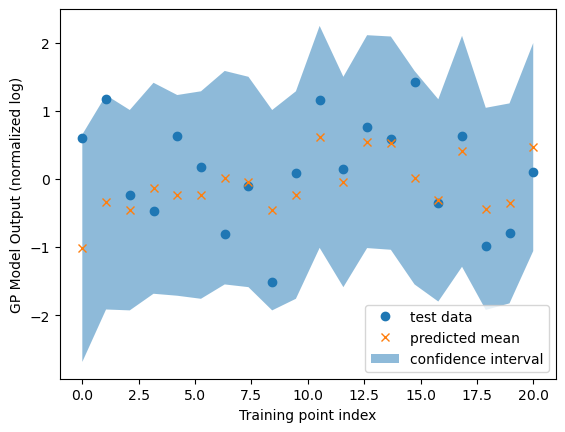

In [ ]:
test_size=y_test.size(dim=0)
print(test_size)
testInds = np.linspace(0,int(test_size),num=test_size)
plt.figure()
plt.plot(testInds,y_test,'o',label = 'test data')
plt.plot(testInds,predictive_mean,'x',label='predicted mean')
#plt.plot(testInds,lower,'-',label = 'lower confidence interval')
#plt.plot(testInds,upper,'-',label = 'upper confidence interval')
plt.fill_between(testInds,lower,upper,alpha=0.5, label = 'confidence interval')
plt.xlabel("Training point index")
plt.ylabel("GP Model Output (normalized log)")
plt.legend(loc=4)

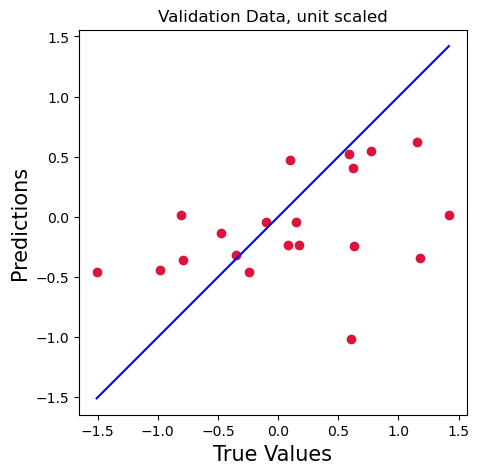

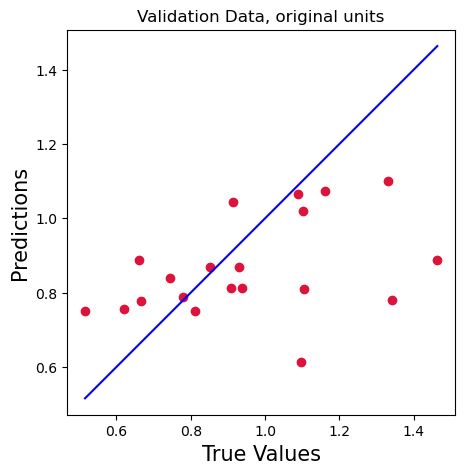

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, predictive_mean, c='crimson')
#plt.scatter(y_test, lower, c='blue')
#plt.scatter(y_test, upper, c='green')

p1 = max(max(predictive_mean), max(y_test))
p2 = min(min(predictive_mean), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Validation Data, unit scaled")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_test_inverse), np.exp(predictive_mean_inverse), c='crimson')
#plt.scatter(y_test, lower, c='blue')
#plt.scatter(y_test, upper, c='green')

p1 = max(max(np.exp(predictive_mean_inverse)), max(np.exp(y_test_inverse)))
p2 = min(min(np.exp(predictive_mean_inverse)), min(np.exp(y_test_inverse)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Validation Data, original units")
plt.show()

In [ ]:
#%% this is where I am trying to get alist of predicted means at the required conditions
P = np.linspace(2.76, 8.27)
T = np.linspace(100, 150)

P, T = np.meshgrid(P, T)  # 2D grid for interpolation
meshes = [P,T]
x_grids = pd.read_csv('gridspace_points_input.csv')
x_pred_old = torch.tensor(np.array(x_grids))
x_pred[:,0] = x_pred_old[:,2]; x_pred[:,1] = x_pred_old[:,0]; x_pred[:,2] = x_pred_old[:,1]
x_pred = torch.tensor(scaler.transform(x_pred))
print(x_pred)


model.eval()
with torch.no_grad():
    trained_pred_dist = likelihood(model(x_pred))
    predictive_mean = trained_pred_dist.mean
    lower, upper = trained_pred_dist.confidence_region()
print(predictive_mean)
# scaling back input/output data
x_pred_inverse = scaler.inverse_transform(x_pred)
predictive_mean_inverse = np.array(np.exp(predictive_mean.reshape(-1,1)))
print('x values', x_pred_inverse)
print('x shape', x_pred_inverse.shape)
print('predicted mean: ', predictive_mean_inverse)
print('predicted mean shape: ', predictive_mean_inverse.shape)
print('x_pred_array_shape')
x_pred_array = np.array(x_pred_inverse)
mean_pred_array = np.array(predictive_mean_inverse)
print(x_pred_array)
print(mean_pred_array)
mean_pred_results = np.concatenate((x_pred_array, mean_pred_array), axis=1)
print(mean_pred_array)
df_results = pd.DataFrame(mean_pred_results)
df_results.to_csv('pred_mean_results.csv', index=False)

tensor([[-1.2517, -0.7364, -0.7448],
        [-1.2517, -0.7004, -0.7448],
        [-1.2517, -0.6643, -0.7448],
        ...,
        [ 0.7989,  0.9583,  1.0144],
        [ 0.7989,  0.9943,  1.0144],
        [ 0.7989,  1.0304,  1.0144]], dtype=torch.float64)
tensor([ 0.5273,  0.5417,  0.5558,  ..., -0.4703, -0.4643, -0.4582],
       dtype=torch.float64)
x values [[  5.           2.76       100.        ]
 [  5.           2.87244898 100.        ]
 [  5.           2.98489796 100.        ]
 ...
 [ 15.           8.04510204 150.        ]
 [ 15.           8.15755102 150.        ]
 [ 15.           8.27       150.        ]]
x shape (7500, 3)
predicted mean:  [[1.69428778]
 [1.71899437]
 [1.74327784]
 ...
 [0.62482744]
 [0.62855092]
 [0.63241902]]
predicted mean shape:  (7500, 1)
x_pred_array_shape
[[  5.           2.76       100.        ]
 [  5.           2.87244898 100.        ]
 [  5.           2.98489796 100.        ]
 ...
 [ 15.           8.04510204 150.        ]
 [ 15.           8.15755102 1

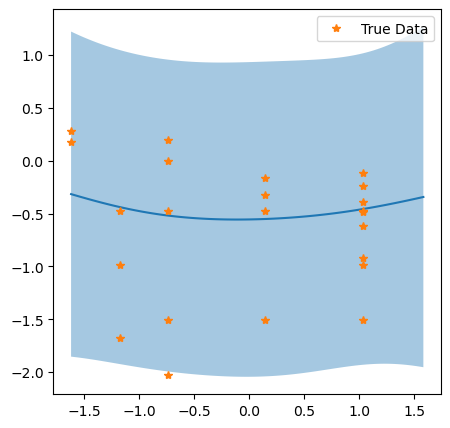

In [ ]:
testPress = torch.linspace(0,10,steps=100)
testTime = torch.ones((100,))*15;  testTemp = torch.ones((100,))*150
testInputs = torch.vstack((testTime,testPress,testTemp)).transpose(0,1)
testInputs = torch.tensor(scaler.transform(testInputs))
with torch.no_grad():
    test_trained_pred_dist = likelihood(model(testInputs))
    test_predictive_mean = test_trained_pred_dist.mean
    test_lower, test_upper = test_trained_pred_dist.confidence_region()

plt.figure(figsize=(5,5))
plt.plot(testInputs[:,1],test_predictive_mean)
plt.fill_between(testInputs[:,1],test_lower,test_upper,alpha=.4)
x=np.array(x)
y=np.array(y)
#print(np.logical_and(x[:,0]==15, x[:,2]==150))
#print(y_scaler.transform(np.log(y[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]).reshape(-1,1)))
#print(np.log(y[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]))
trueYs = y_scaler.transform(np.log(y[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]).reshape(-1,1))
#trueYs = y[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]
trueXs = scaler.transform(x[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))])[:,1]
#trueXs = x[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]
plt.plot(trueXs,trueYs,'*',label='True Data')
plt.legend()
#plt.scatter()

# transform to original coordinates correctly, differentiate bt test/training points


In [ ]:
x = np.array(x); y=np.array(y)
print(np.where((x[:,0]==15)) and np.where(x[:,2]==150))
print(np.where(np.logical_and(x[:,0]==15, x[:,2]==150)))
print(np.where((x[:,2]==150))  )
print(x[np.where((x[:,0]==15)) and np.where(x[:,2]==150)]) 
print(model.mean_module.constant)
model.covar_module.base_kernel.lengthscale

(array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),)
(array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
       91, 92, 93, 94, 95, 96]),)
(array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),)
[[  0.           0.         150.        ]
 [  0.           0.         150.        ]
 [  5.           0.         150.        ]
 [  5.           2.757904   150.        ]
 [  5.           2.757904   150.        ]
 [  5.           4.28854072 150.        ]
 [  5.           4.28854072 150.        ]
 [  5.           5.515808   150.        ]
 [  5.           5.515808   150.        ]
 [  5.           8.273712   150.        ]
 [  5.           8.273712   150.        ]
 [  5.    

tensor([[2.8396, 1.1232, 0.0404]], grad_fn=<SoftplusBackward0>)